# Snowfall detection

This notebook uses the lidar snow depth curve obtained at one point to automatically detect beginning and end of snowfalls, as well as beginning and end of snow erosion/melt.
We use rolling (in time) standard deviation to detect abrupt changes in snow depth. We use two desynchronized rolling (in time) means to know if the general evolution of snow depth is increasing or decreasing (depending on the sign of the difference between the two rolling means).

### Imports

In [23]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import numpy as np

### Imported functions

In [24]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


### Detection of snow events functions

In [8]:

def get_snow_events(ds, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the sign of the difference between
    a rolling mean centerd left and a rolling mean centered right
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
        time_window_mean: size of the rolling window to compute each mean (left and right)
        time_window_mean_diff: size of the rolling window to compute the difference between the two rolling means
        mean_diff_offset: index offset to take into account the lag due to rolling window size
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
    mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_diff, center=True).mean(dim='time').values

    snow_events_occurrences = stdev > 0.02   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        if mean_right_minus_mean_left[start_time_indices[index] + mean_diff_offset] >= 0:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


### Define data

In [5]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')


In [6]:
# Pre-processing to get clean data

data_dec_jan_feb = data_dec_jan_feb.ffill(dim='time')
median_spacetime_filtering(data_dec_jan_feb, 11)
data_dec_jan_feb['snow_surface'] = data_dec_jan_feb['snow_surface'] - data_dec_jan_feb['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]


### Define parameters and compute events' timing

In [11]:
# Defining parameters

x_sel = 11
y_sel = 11
time_window_std = 25
time_window_mean = 19
time_window_mean_diff = 51
mean_diff_offset = 20


In [12]:
# Get events' timing

results = get_snow_events(data_dec_jan_feb, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


/tmp/ipykernel_7886/2087010241.py:17: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
/tmp/ipykernel_7886/2087010241.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
/tmp/ipykernel_7886/2087010241.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_di

### Plot accumulation/erosion events as computed

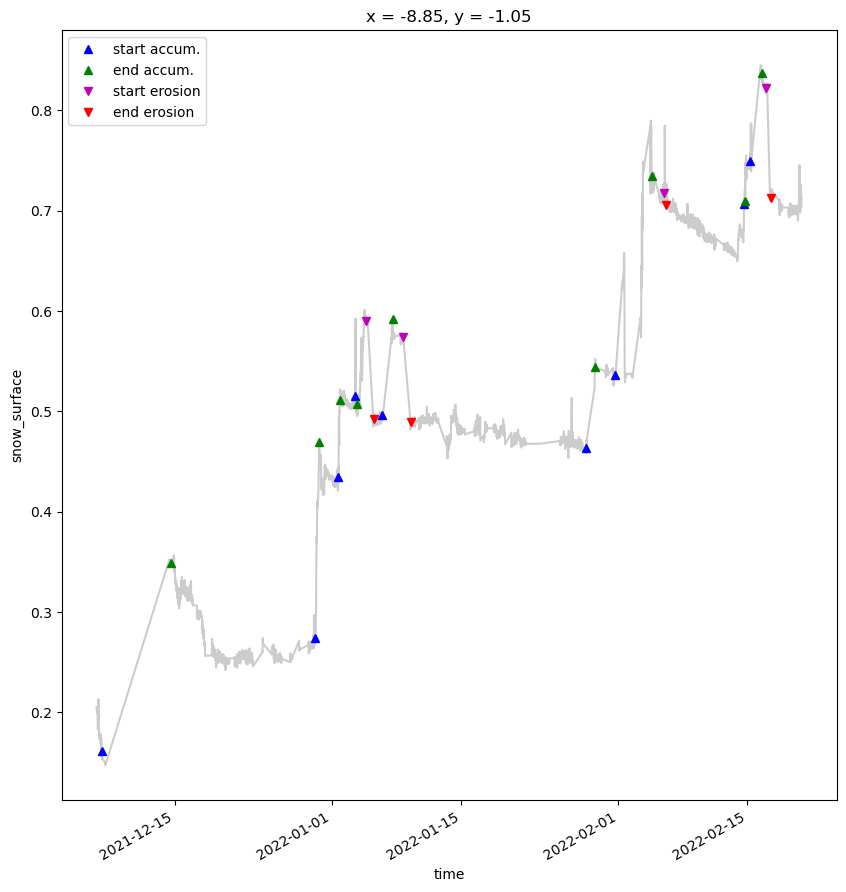

In [22]:
# Plot the snow-depth curve with timing of snow events

plt.figure(figsize=(10, 10))
data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')
plt.legend()
